In [1]:
from keras.models import Sequential,Model
from keras.layers import Dense,Activation,Input, Conv2D
import keras.callbacks
import keras.backend as K
import tensorflow as tf
from keras import losses
import numpy as np

Using TensorFlow backend.


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)
#os.environ["CUDA_VISIBLE_DEVICES"]="1" #"0" for the 1st GPU or "1" to use the 2nd

In [3]:
#%%DATA INITIALIZATION
import numpy as np
from AlphaTransform import AlphaShearletTransform as AST
import shape_constraint.cadmos_lib as cl
import os

code_path = '/Path/To/Code/'

row,column = np.array([96,96])
U = cl.makeUi(row,column)

gamma = 1 #trade-off parameter

# Get shearlet elements
#Step 1 : create a shearlet transform instance
trafo = AST(column, row, [0.5]*3,real=True,parseval=True,verbose=False)
#Step 2 : get shearlets filters
shearlets = trafo.shearlets
#Step 3 : get the adjoints
adjoints = cl.get_adjoint_coeff(trafo)

#Normalize shearlets filter banks
#/!\ The order is important/!\
adjoints = cl.shear_norm(adjoints,shearlets)
shearlets = cl.shear_norm(shearlets,shearlets)

#Compute moments constraint normalization coefficients
#the $\Psi^*_j$ are noted adj_U
adj_U = cl.comp_adj(U,adjoints).reshape(6,27,1,96,96,1)
mu = cl.comp_mu(adj_U)


/home/cben-ali/Programs/deep-deconv/python/shape_constraint/cadmos_lib.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [55]:
adj_U.shape

(6, 27, 1, 96, 96, 1)

In [58]:
from keras import losses

ndim_in=96
ndim_lay=3
ndim_out=2

K.clear_session()

def custom_mse_3(ytrue,ypred):
    @tf.custom_gradient
    def closs(ypred):
        loss=K.mean(K.square(ytrue-ypred),axis=-1)
        print('loss',K.int_shape(loss))
        def grad(dy):
            print('grad',K.int_shape(2*K.expand_dims(dy,axis=-1)*(ypred-ytrue)))
            return (2*K.expand_dims(dy,axis=-1)*(ypred-ytrue))/K.int_shape(ypred)[-1]
        return loss,grad
    return closs(ypred)

def custom_loss(ytrue,ypred):
    @tf.custom_gradient
    def closs(ypred):
        residual=ypred-ytrue
        temp=0
        temp_grad=0
        loss=K.mean(K.square(ytrue-ypred),axis=-1)
        print('loss',K.int_shape(loss))
        for i in range(6):
            for j in range(27):
                temp+=mu[i,j]*K.square(K.sum(residual*adj_U[i,j],axis=(1,2,3)))
                temp_grad+=mu[i,j]*K.sum(residual*adj_U[i,j],axis=(1,2,3))*adj_U[i,j]
        temp=K.expand_dims((K.expand_dims(temp, axis=-1)),axis=-1)
        temp_grad=K.permute_dimensions(temp_grad,(3,1,2,0))
        print('temp',K.int_shape(temp))
        temp/=ndim_in*ndim_in
        temp_grad/=ndim_in*ndim_in
        loss+=temp  
        def grad(dy):
            return (2*(ypred-ytrue)+temp_grad)*K.expand_dims(dy,axis=-1)
        return loss,grad
    loss=closs(ypred)
    print(type(loss))
    return closs(ypred)


inputs = Input((ndim_in,ndim_in,1),name="inname")
lay = Conv2D(ndim_lay,name="layname",kernel_size=(2,2),padding='same')(inputs)
out=  Conv2D(ndim_out,name="outname",kernel_size=(2,2),padding='same')(lay)
print(K.int_shape(inputs))
print(K.int_shape(out))
net=keras.Model(input = inputs, outputs =out)
net.compile(optimizer = keras.optimizers.Adam(lr=1e-3), loss =custom_loss )
#net._collected_trainable_weights.append(out)
net.summary()
grads=[net.optimizer.get_gradients(net.total_loss,net._collected_trainable_weights)]

net2=keras.Model(input = inputs, outputs =out)
net2.compile(optimizer = keras.optimizers.Adam(lr=1e-3), loss =losses.mean_squared_error )
net2.summary()
grads2=[net2.optimizer.get_gradients(net2.total_loss,out)]


nbatch=4

sess = tf.Session()
vinput=np.random.rand(nbatch,ndim_in,ndim_in,1)#np.zeros((nbatch,ndim_in))+1
vtruth=np.random.rand(nbatch,ndim_in,ndim_in,2)#np.zeros((nbatch,ndim_out))+2
weight=np.zeros((nbatch))+1

ninp=net.inputs[0]
ntarget=net.targets[0]
nsampleweights=net.sample_weights[0]

ninp2=net2.inputs[0]
ntarget2=net2.targets[0]
nsampleweights2=net2.sample_weights[0]


print(sess.run(tf.report_uninitialized_variables()))
print(sess.run(tf.global_variables_initializer()))
vout=sess.run(out,feed_dict={ninp:vinput, ntarget:vtruth,nsampleweights:weight})
print("VOUT=",vout)

#print(sess.run(net._set_inputs(vinput, outputs=vtruth, training=True)))
print("COST_FUNCTION=",net.evaluate( x=vinput,y=vtruth))
print("COST_FUNCTION2=",net2.evaluate(x=vinput,y=vtruth))
print("MANUAL COST_FUNCTION=",np.sum((vout-vtruth)**2)/(2*nbatch*ndim_in*ndim_in))

print("GRAD_MANUAL=",2*(vout-vtruth)/(2*nbatch*ndim_in*ndim_in))
print("GRAD=",sess.run(grads,feed_dict={ninp:vinput, ntarget:vtruth,nsampleweights:weight}))
print("GRAD2=",sess.run(grads2,feed_dict={ninp2:vinput, ntarget2:vtruth,nsampleweights2:weight}))

print((np.array(sess.run(grads2,feed_dict={ninp2:vinput, ntarget2:vtruth,nsampleweights2:weight})).shape))

(None, 96, 96, 1)
(None, 96, 96, 2)
loss (None, 96, 96)


/local/home/fsureau/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., inputs=Tensor("in...)`


temp (None, 1, 1)
<class 'tensorflow.python.framework.ops.Tensor'>
loss (None, 96, 96)
temp (None, 1, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inname (InputLayer)          (None, 96, 96, 1)         0         
_________________________________________________________________
layname (Conv2D)             (None, 96, 96, 3)         15        
_________________________________________________________________
outname (Conv2D)             (None, 96, 96, 2)         26        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


/local/home/fsureau/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., inputs=Tensor("in...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inname (InputLayer)          (None, 96, 96, 1)         0         
_________________________________________________________________
layname (Conv2D)             (None, 96, 96, 3)         15        
_________________________________________________________________
outname (Conv2D)             (None, 96, 96, 2)         26        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
[b'layname/kernel' b'layname/bias' b'outname/kernel' b'outname/bias'
 b'Adam/iterations' b'Adam/lr' b'Adam/beta_1' b'Adam/beta_2' b'Adam/decay'
 b'Adam_1/iterations' b'Adam_1/lr' b'Adam_1/beta_1' b'Adam_1/beta_2'
 b'Adam_1/decay']
None
VOUT= [[[[-4.64052111e-02 -9.24164355e-02]
   [-2.20646814e-01 -4.06549461e-02]
   [-2.24410608e-01 -1.13222942e-01]
   ...
   [ 9.74253193e-02 -3.78429353e-01]
   [-1.644360

GRAD= [[array([[[[-0.20633745, -0.25241998,  0.44443497]],

        [[-0.21010515, -0.43248987,  0.41204298]]],


       [[[-0.1932844 , -0.47607964,  0.40137634]],

        [[-0.18013081, -0.31130135,  0.44232345]]]], dtype=float32), array([-0.3904029 , -0.7410238 ,  0.78569126], dtype=float32), array([[[[ 0.4084727 ,  0.28438473],
         [ 0.1541773 ,  0.10083982],
         [-1.0880195 , -0.8282928 ]],

        [[ 0.3929561 ,  0.323201  ],
         [ 0.07153297,  0.12090474],
         [-1.101686  , -0.8125858 ]]],


       [[[ 0.38304472,  0.33357766],
         [ 0.05498801,  0.07776485],
         [-1.0573322 , -0.84504527]],

        [[ 0.42683092,  0.28376168],
         [ 0.1332832 ,  0.02489786],
         [-1.0943182 , -0.7981134 ]]]], dtype=float32), array([-1.6215886, -1.231504 ], dtype=float32)]]
GRAD2= [[array([[[[-1.34516322e-05, -1.76288140e-05],
         [-2.09825175e-05, -2.53006237e-05],
         [-2.22491235e-05, -1.12964062e-05],
         ...,
         [-8.52391076e-0

In [50]:
arr_ts=(np.asarray(sess.run(grads2,feed_dict={ninp2:vinput, ntarget2:vtruth,nsampleweights2:weight})))
arr_ts[0,3].shape

(2,)

In [12]:
vinput=np.random.rand(4,96,96,1)#np.zeros((nbatch,ndim_in))+1
vtruth=np.random.rand(4,96,96,2)
residual=K.variable(vinput-vtruth)
K.int_shape(K.variable(residual))
adj_U.shape


(6, 27, 1, 96, 95, 1)

In [94]:
net.fit(vinput,vtruth,batch_size=nbatch,epochs=2)

Epoch 1/2
4/4 [==============================] - 0s 8ms/step - loss: 0.3184
Epoch 2/2
4/4 [==============================] - 0s 7ms/step - loss: 0.3156


In [16]:
K.int_shape(K.mean((2*K.variable(vinput)*(residual)),axis=-1))

(4, 96, 96)

In [84]:
temp=0
temp_grad=0
loss=K.mean(K.square(residual),axis=-1)
print('loss',K.int_shape(loss))
for i in range(6):
    for j in range(27):
        temp+=mu[i,j]*K.square(K.sum(residual*adj_U[i,j],axis=(1,2,3)))
        temp_grad+=mu[i,j]*K.sum(residual*adj_U[i,j],axis=(1,2,3))*adj_U[i,j]
temp=K.expand_dims((K.expand_dims(temp, axis=-1)),axis=-1)
temp_grad=K.reshape(temp_grad,(4,96,96))
print('temp',K.int_shape(temp))
loss+=temp
print('temp grad',K.int_shape(temp_grad)) 
print(loss)

loss (4, 96, 96)
temp (4, 1, 1)
temp grad (1, 96, 96, 4)
Tensor("add_2274:0", shape=(4, 96, 96), dtype=float32)


In [19]:
vtrue = tf.placeholder(dtype='float32', shape=(1,3,1))
grads

[<tf.Tensor 'gradients_3/dense_4/Reshape_grad/Reshape:0' shape=(?, 3, 1) dtype=float32>]

In [119]:
a=Input(shape=(1,))
b=Dense(1,name="b")(a)

net = Model(inputs=a, outputs=b)
net.compile(optimizer='Adam',loss=mse_test)
#net.compile(optimizer='rmsprop',loss=losses.mean_squared_error)

In [108]:
K.int_shape(b)

(None, 1)

In [4]:
#%%DATA INITIALIZATION
import numpy as np
from AlphaTransform import AlphaShearletTransform as AST
import shape_constraint.cadmos_lib as cl
import os

code_path = '/Path/To/Code/'

row,column = np.array([96,96])
U = cl.makeUi(row,column)

gamma = 1 #trade-off parameter

# Get shearlet elements
#Step 1 : create a shearlet transform instance
trafo = AST(column, row, [0.5]*3,real=True,parseval=True,verbose=False)
#Step 2 : get shearlets filters
shearlets = trafo.shearlets
#Step 3 : get the adjoints
adjoints = cl.get_adjoint_coeff(trafo)

#Normalize shearlets filter banks
#/!\ The order is important/!\
adjoints = cl.shear_norm(adjoints,shearlets)
shearlets = cl.shear_norm(shearlets,shearlets)

#Compute moments constraint normalization coefficients
#the $\Psi^*_j$ are noted adj_U
adj_U = cl.comp_adj(U,adjoints)
mu = cl.comp_mu(adj_U)


/home/cben-ali/Programs/deep-deconv/python/shape_constraint/cadmos_lib.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [13]:
shearlets.shape

(27, 96, 96)

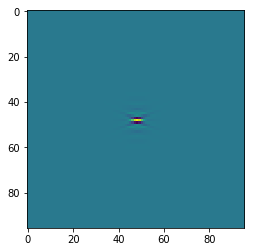

In [17]:
from matplotlib import pyplot as plt
plt.imshow(adjoints[24,:,:])

In [ ]:
o